In [1]:
#import kaggle
#!pip install timm

#kaggle.api.authenticate()
#kaggle.api.dataset_download_files('gpiosenka/cards-image-datasetclassification', path='data', unzip=True)

# 3 Problems:
    1. Pytorch Datasets
    2. Pytorch Model
    3. Pytorch training Loop

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
from PIL import Image

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

/anaconda/envs/azureml_py38/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


System Version: 3.9.19 | packaged by conda-forge | (main, Mar 20 2024, 12:50:21) 
[GCC 12.3.0]
PyTorch version 1.13.1
Torchvision version 0.14.1+cu117
Numpy version 1.23.5
Pandas version 1.3.5


In [3]:
class CardDatasets(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

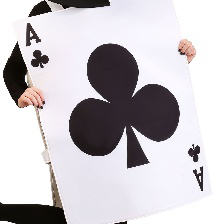

In [4]:
data_dir = 'data/train'
dataset = CardDatasets(data_dir)
show_img = dataset[0][0]
show_img

13


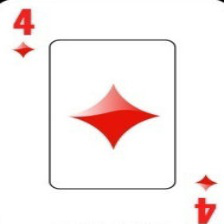

In [5]:
image, label =dataset[2000]
print(label)
image

In [6]:
#getting dictonary of classes

data_dir = 'data/train'
target_to_class = {i: class_name for i, class_name in enumerate(sorted(os.listdir(data_dir)))}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [7]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

In [8]:
dataset = CardDatasets(data_dir, transform)

In [9]:
image, label = dataset[100]
image.shape

torch.Size([3, 150, 150])

In [10]:
# iterate over dataset

for image, label in dataset:
    break

# Dataloader:
    1. Batching datasets

In [11]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [12]:
for images, labels in dataloader:
    break

In [13]:
images.shape, labels.shape

(torch.Size([32, 3, 150, 150]), torch.Size([32]))

In [14]:
labels

tensor([ 2, 43,  2, 21, 19, 22, 11, 30, 42, 46,  7, 22,  5, 28,  9, 47, 36, 33,
        40, 14, 46, 39, 52, 19, 39, 43, 47, 18, 34, 11, 50,  3])

# Pytorch Model:

In [15]:
class SimpleCardModel(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardModel, self).__init__()
        #Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # make a classifier
        self.classifier = nn.Linear(enet_out_size, num_classes)

    def forward(self, x):
        #Where we define the forward pass
        x = self.features(x)
        output = self.classifier(x)
        return output

In [16]:
model = SimpleCardModel(num_classes=53)
print(str(model)[:500])

SimpleCardModel(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)



In [17]:
model(images)

tensor([[-0.0630, -0.1742,  0.0136,  ..., -0.0720,  0.3478, -0.3287],
        [ 0.2265,  0.2721,  0.3772,  ..., -0.2918, -0.0192, -0.0535],
        [ 0.1669,  0.0411,  0.0299,  ...,  0.0399,  0.0423, -0.7519],
        ...,
        [ 0.4453, -0.1655, -0.2684,  ...,  0.2909, -0.3013,  0.0207],
        [ 0.1964, -0.0787,  0.7665,  ...,  0.3706,  0.0331, -0.6123],
        [ 0.0009, -0.3864,  0.2115,  ...,  0.0607, -0.2618,  0.0800]],
       grad_fn=<AddmmBackward0>)

# Training

In [18]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 53]) torch.Size([32])


## Setup Datasets

In [20]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

train_folder = 'data/train/'
valid_folder = 'data/valid/'
test_folder = 'data/test/'

train_dataset = CardDatasets(train_folder, transform=transform)
val_dataset = CardDatasets(valid_folder, transform=transform)
test_dataset = CardDatasets(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Simple Training Loop

In [21]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardModel(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.4450900900526538, Validation loss: 0.42152051295874254


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.4772506028507589, Validation loss: 0.1570352110660301


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.28613934207781916, Validation loss: 0.15198144035519295


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.20897773952308382, Validation loss: 0.15434504477482922


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.1568542075385452, Validation loss: 0.07775344658853872


## Visualize Losses

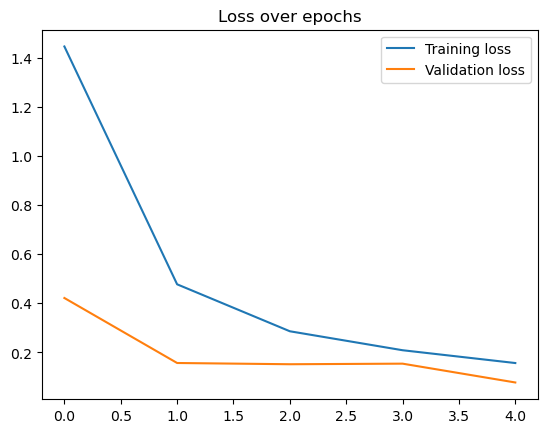

In [22]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Evaluating the Results


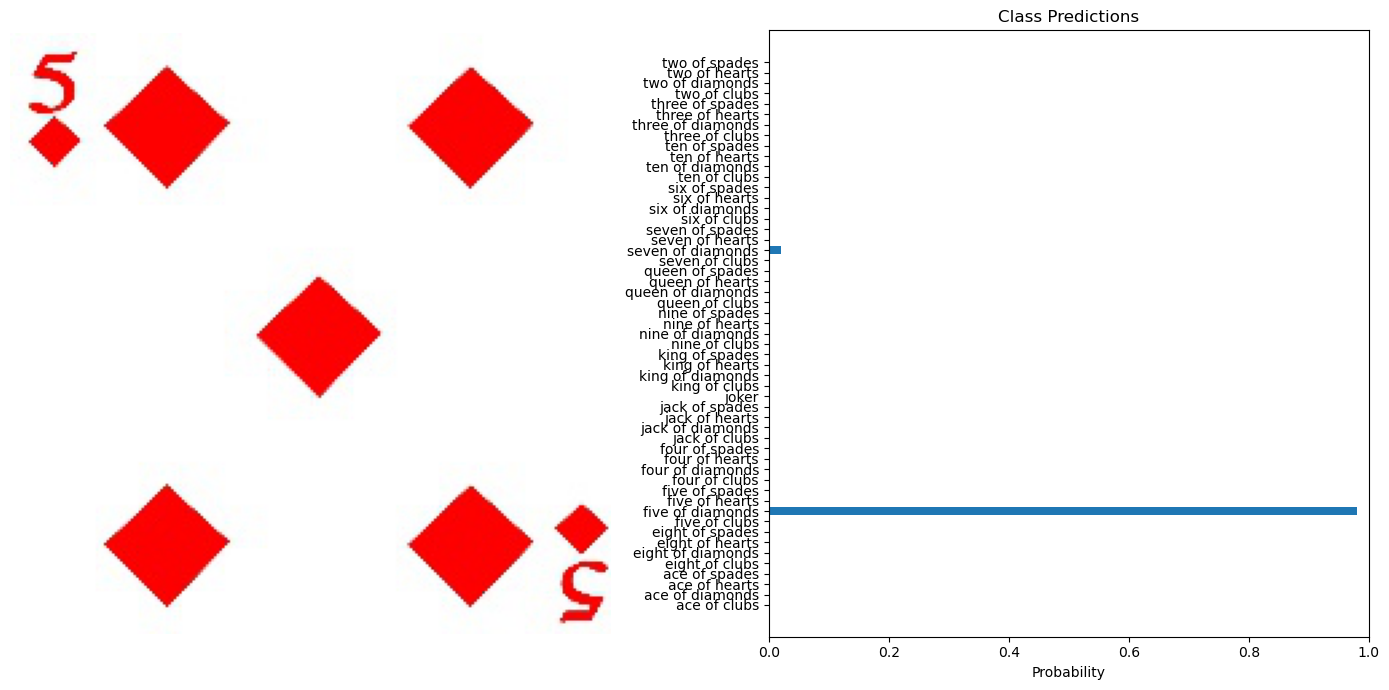

In [23]:
# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "data/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

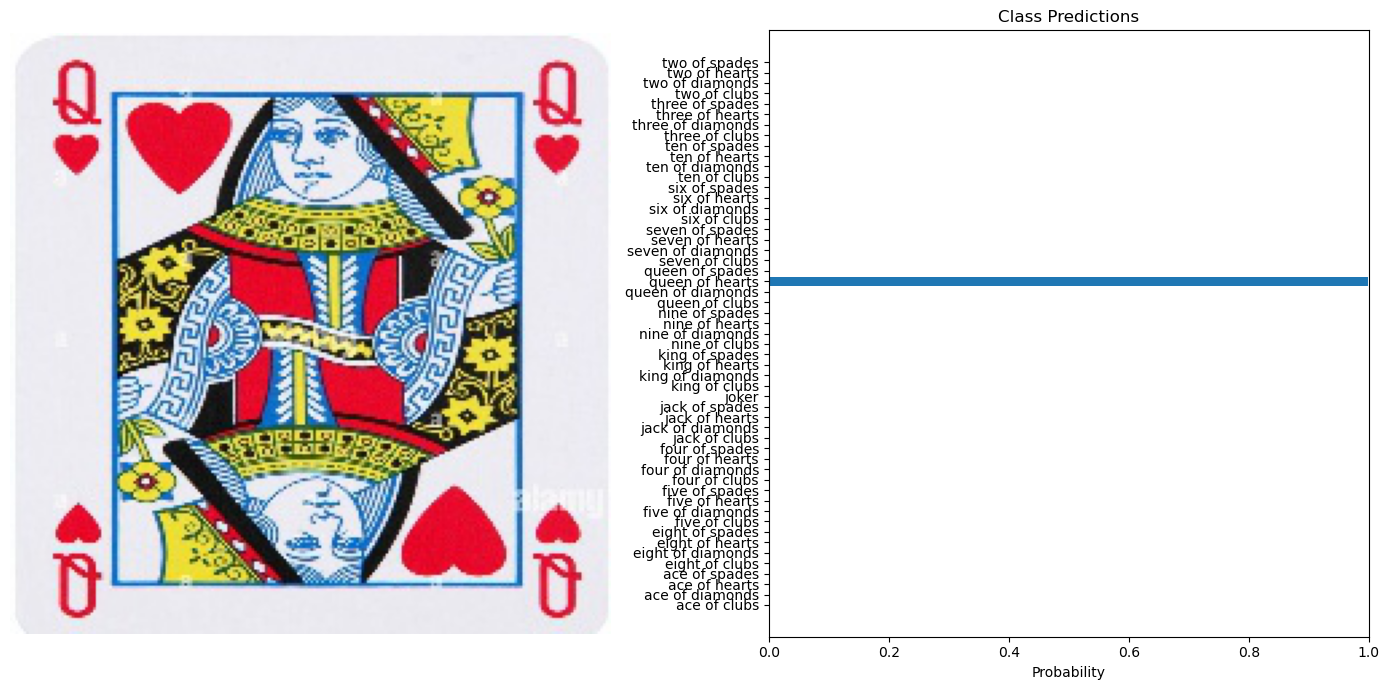

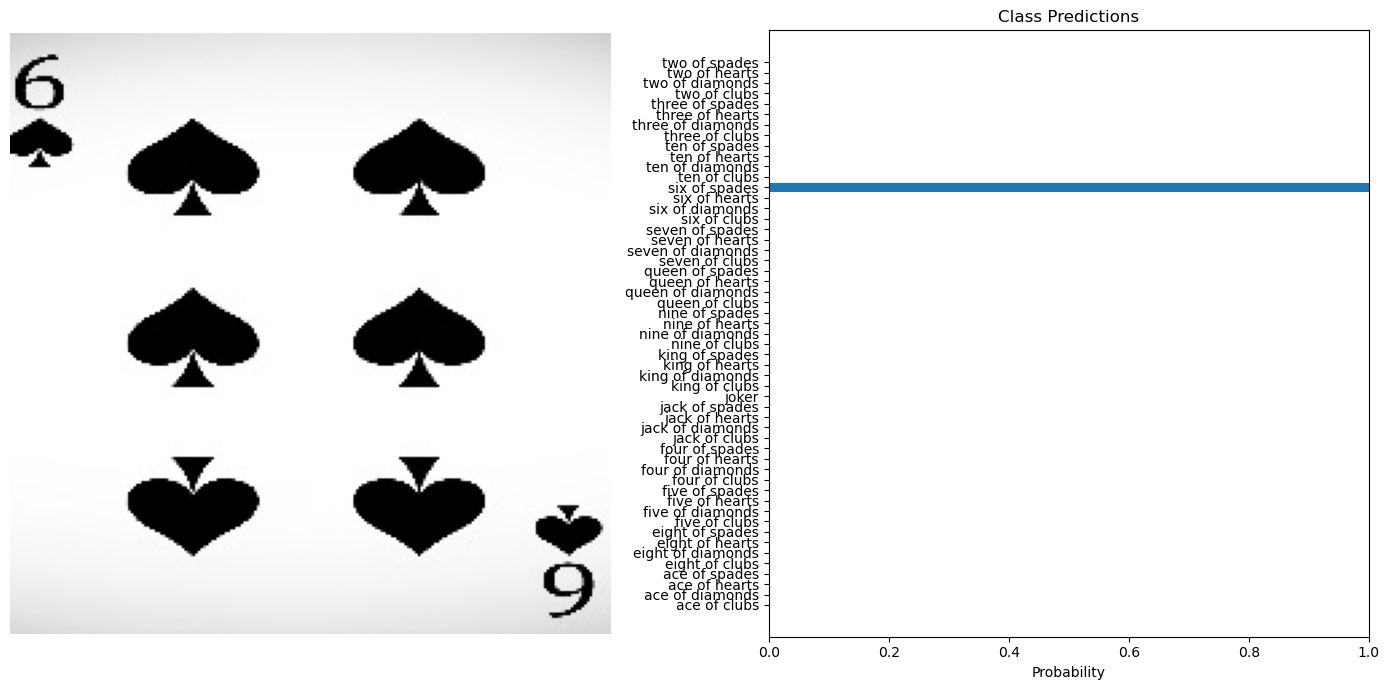

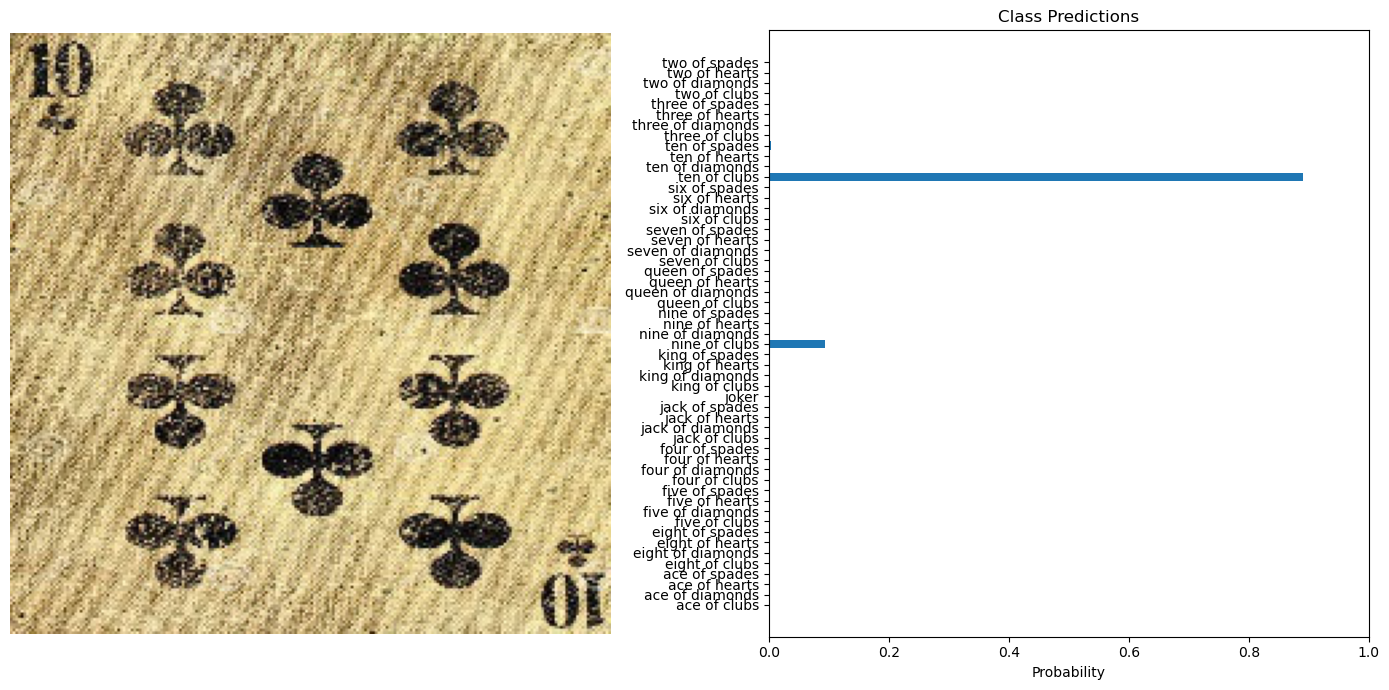

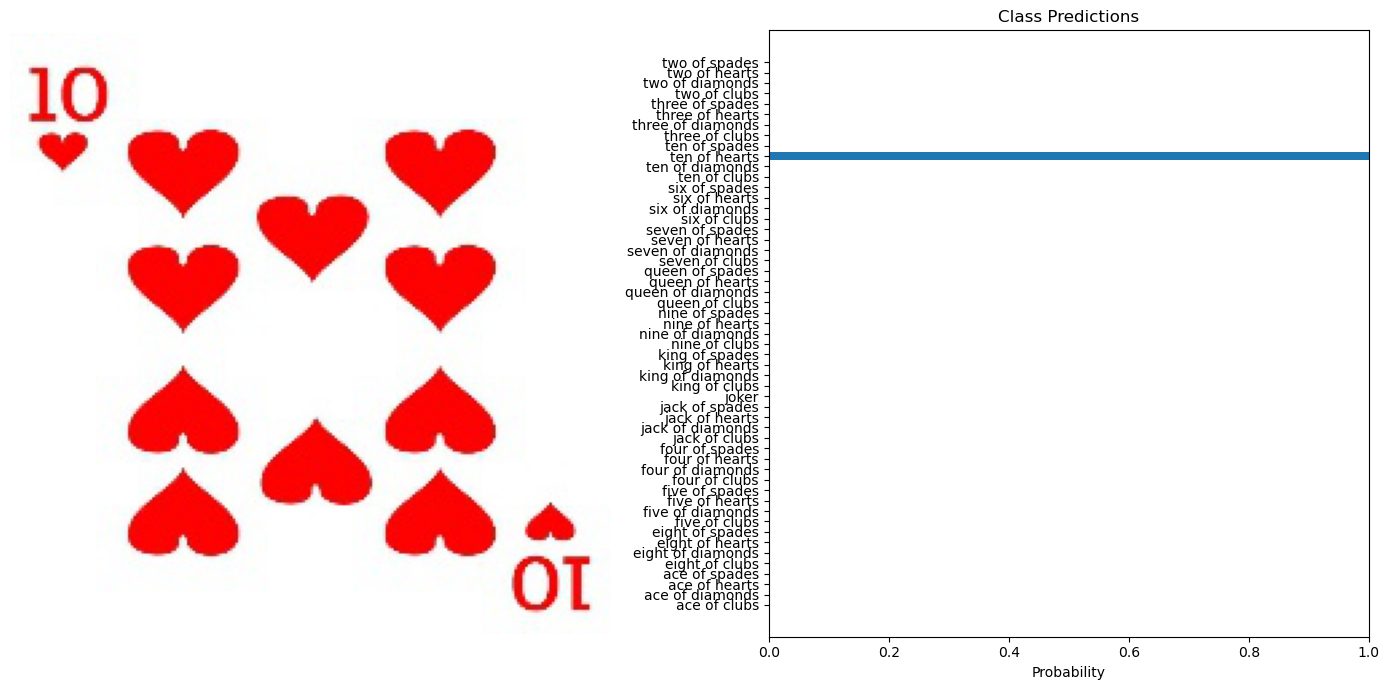

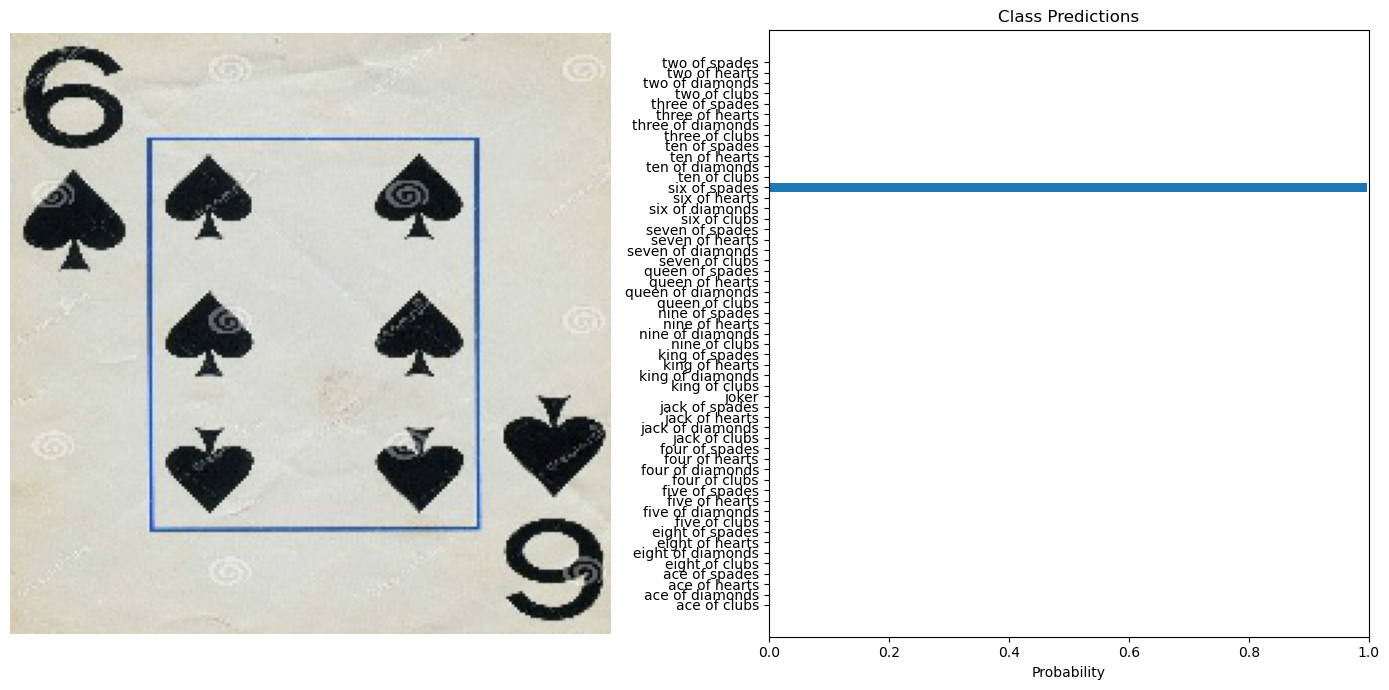

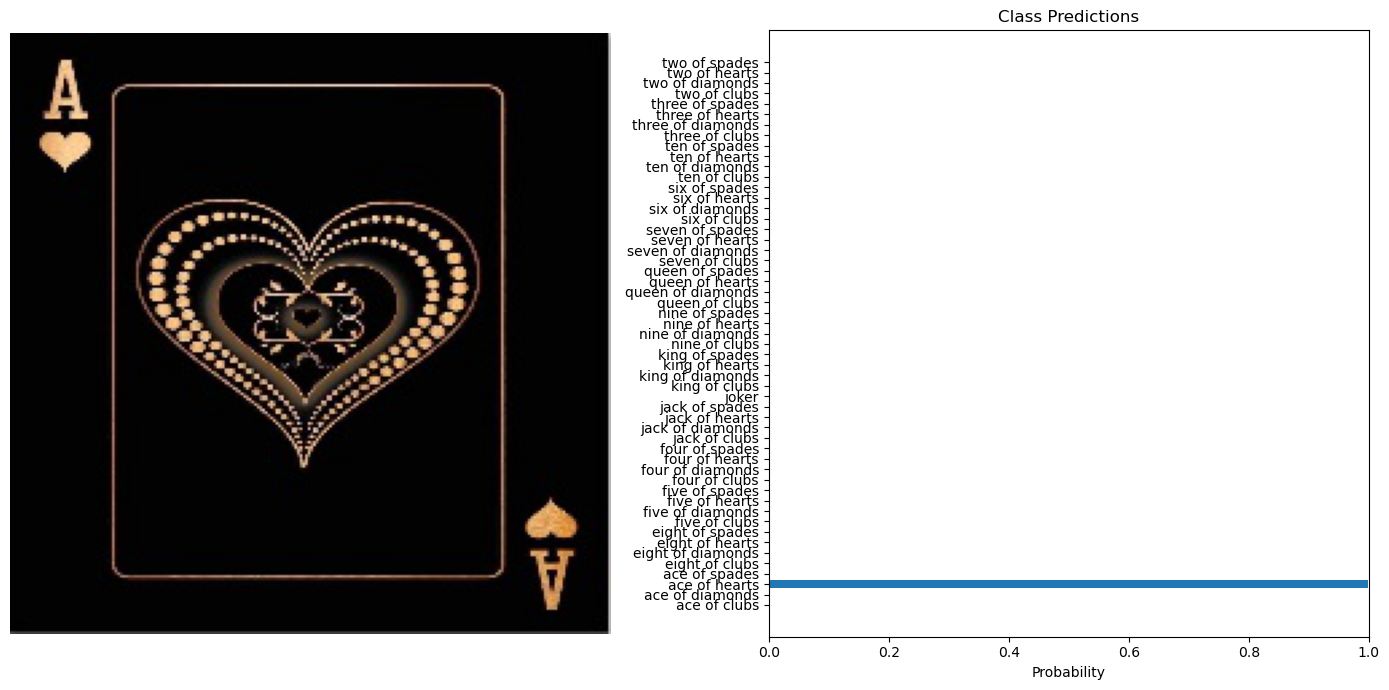

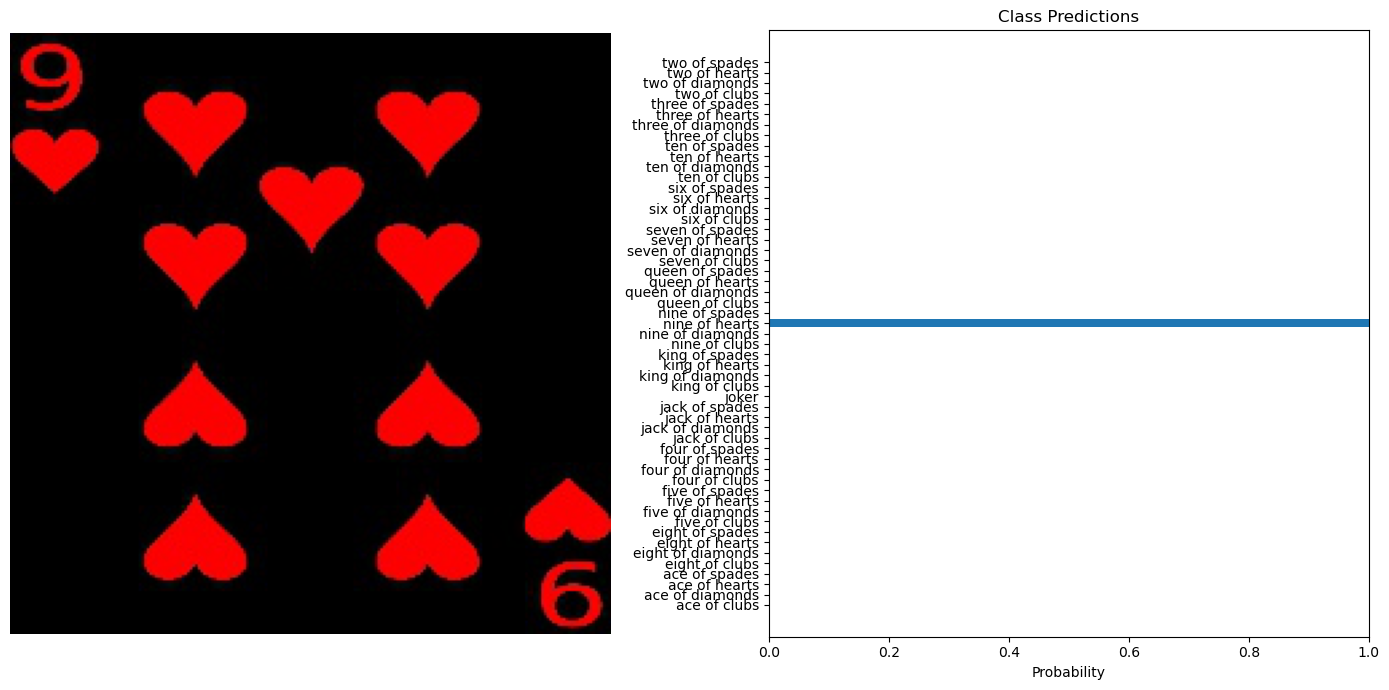

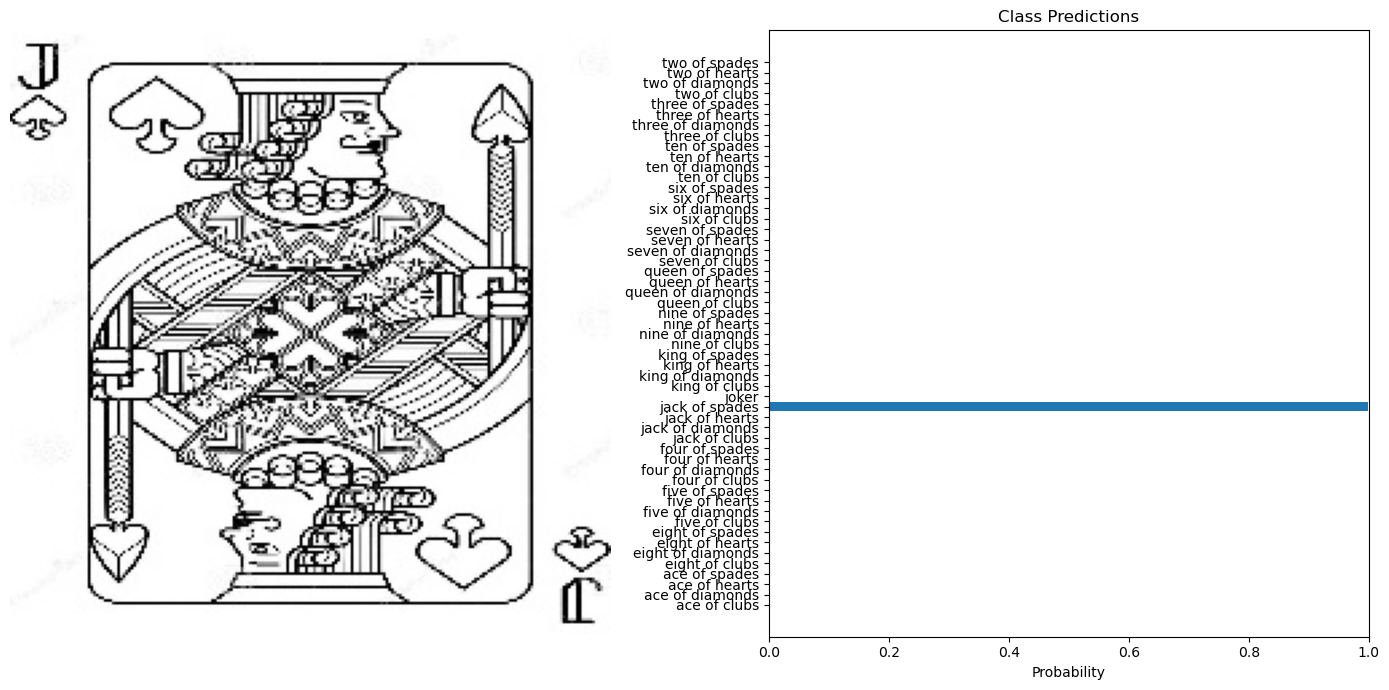

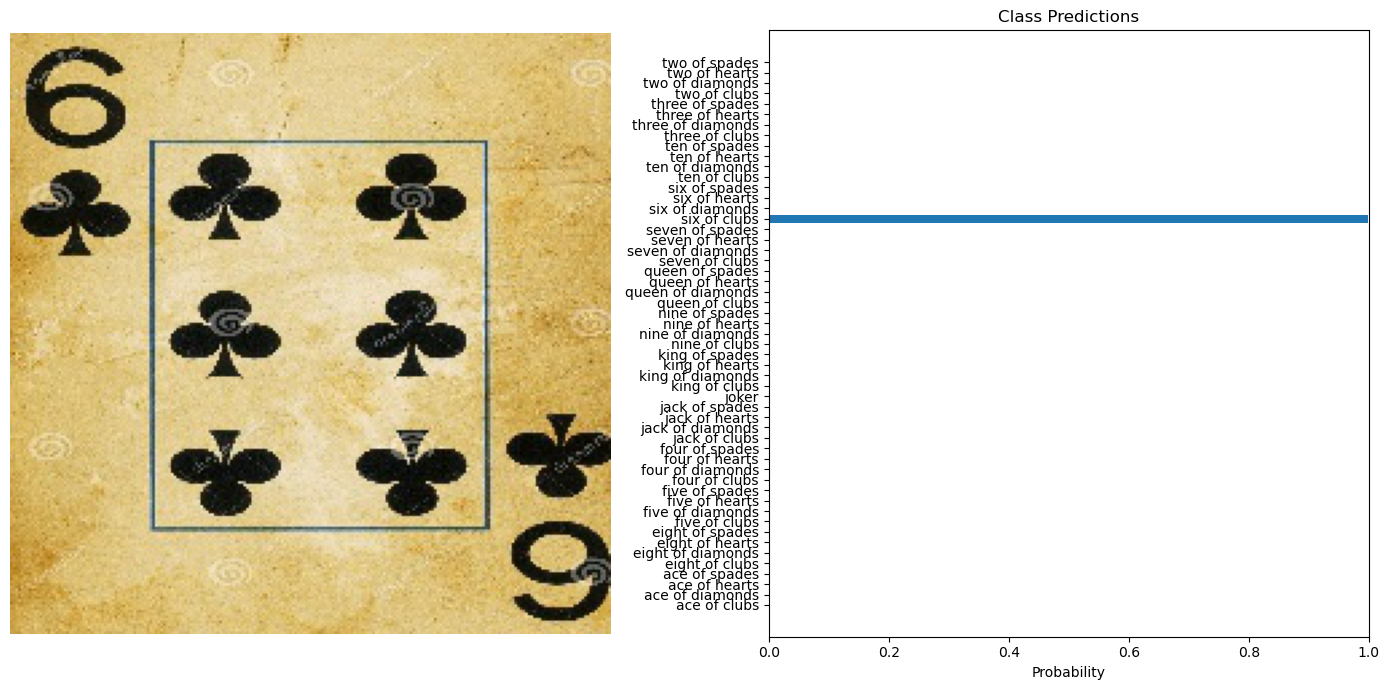

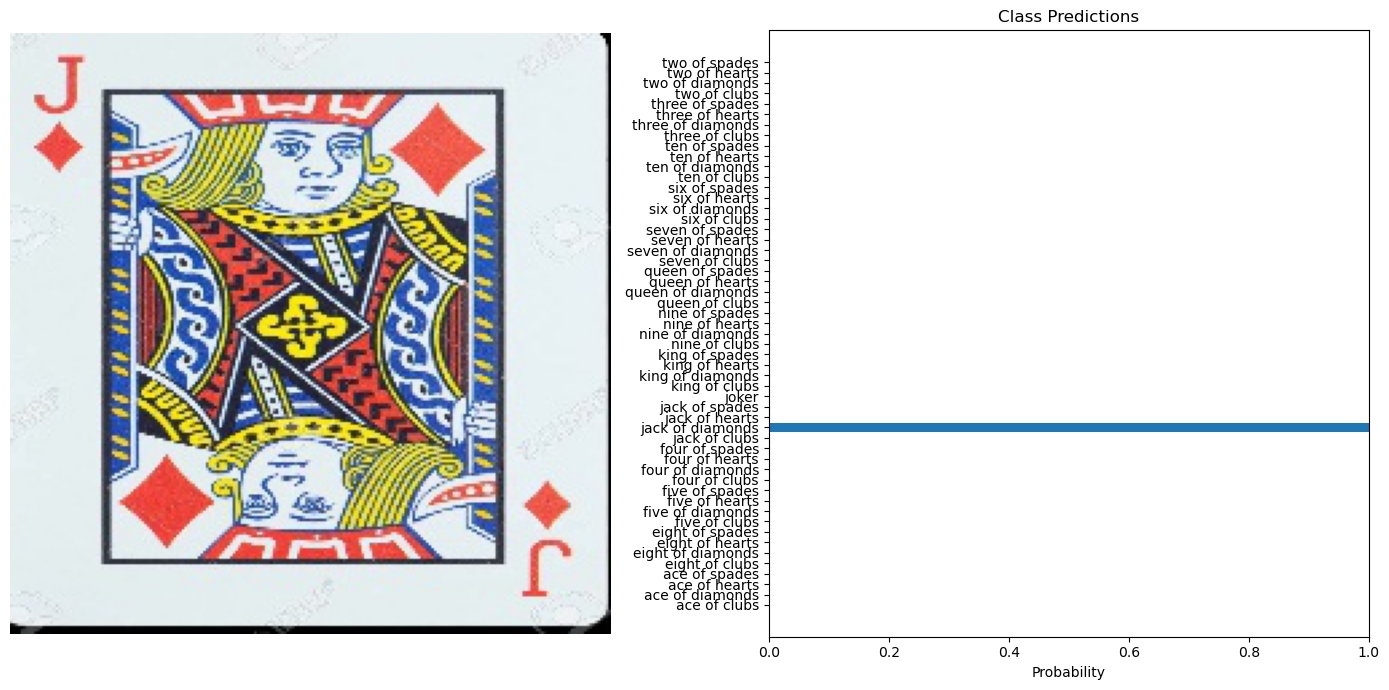

In [24]:
from glob import glob
test_images = glob('data/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)